## News Aggregator Dataset

**Data source**: [Kaggle - News Aggregator Dataset](https://www.kaggle.com/datasets/uciml/news-aggregator-dataset)

This dataset contains **headlines**, **URLs**, and **categories** for **422,937 news stories** collected by a web aggregator between **March 10th, 2014** and **August 10th, 2014**.

### Categories Included:
- Business
- Science and Technology
- Entertainment
- Health

Articles that refer to the same news item (e.g., multiple stories about newly released employment statistics) are grouped together under the same category.


# Fetch Data

In [1]:
import boto3
import sagemaker

import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
!pip install -q WordCloud
from wordcloud import WordCloud

In [3]:
#!/bin/bash

# Download the dataset
!curl -L -o ./news-aggregator-dataset.zip \
  https://www.kaggle.com/api/v1/datasets/download/uciml/news-aggregator-dataset


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 27.9M  100 27.9M    0     0  54.6M      0 --:--:-- --:--:-- --:--:-- 54.6M


In [4]:
!unzip -d news-aggregator-dataset news-aggregator-dataset.zip

Archive:  news-aggregator-dataset.zip
  inflating: news-aggregator-dataset/uci-news-aggregator.csv  


In [5]:
!ls news-aggregator-dataset

uci-news-aggregator.csv


In [6]:
!head -n 2 ./news-aggregator-dataset/uci-news-aggregator.csv


ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
1,"Fed official says weak data caused by weather, should not slow taper","http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss",Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698


In [7]:
DEST_PATH = './news-aggregator-dataset/uci-news-aggregator.csv'

In [8]:
# col_names = ['id', 'title', 'url', 'publisher', 'category', 'story', 'host', 'ts']
# df = pd.read_csv(S3_URL, sep='\t', names=col_names, low_memory=False)

df = pd.read_csv(DEST_PATH, low_memory=False)
df = df[['TITLE', 'CATEGORY']]
df.shape

(422419, 2)

In [9]:
df.head()

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [10]:
df['CATEGORY'].value_counts()

CATEGORY
e    152469
b    115967
t    108344
m     45639
Name: count, dtype: int64

In [11]:
# Mapping dictionary
category_map = {
    'b': 'business',
    'e': 'entertainment',
    'm': 'medicine/health',
    't': 'tech/science'
}

# Add new column
df['category_full'] = df['CATEGORY'].map(category_map)
df.sample(10)

,TITLE,CATEGORY,category_full
415434,Beyonce Wins Video Vanguard Award: Jay Z & Blu...,e,entertainment
132854,Wealthiest hip-hop artists of 2014,t,tech/science
227617,Virus causes McCartney to cancel entire Japan ...,e,entertainment
87418,Japan and Australia in Pact to Lower Tariffs o...,b,business
319019,"Wait, Why Is Peeta Evil Now?",e,entertainment
219568,Asian shares decline on China slowdown,b,business
388754,'Planes: Fire & Rescue' is more filler than fe...,e,entertainment
14235,Honda recalls nearly 9 lakh Odyssey vans in US,t,tech/science
348130,Dollar rises in Asia on upbeat sentiment,b,business
91502,St. Louis Fed Economist: Bitcoin Could Be A Go...,b,business


In [12]:
DEST_PATH = './news-aggregator-dataset/news-aggregator.csv'

df.to_csv(DEST_PATH, index=False)

In [13]:
!head -n 3 ./news-aggregator-dataset/news-aggregator.csv

TITLE,CATEGORY,category_full
"Fed official says weak data caused by weather, should not slow taper",b,business
Fed's Charles Plosser sees high bar for change in pace of tapering,b,business


# Upload Data to S3 bucket

In [14]:
iam = boto3.client('iam')
session = sagemaker.Session()
role = sagemaker.get_execution_role() # role_arn
print('My execution role: ', role)

role_name = role.split('/')[-1]
# give this executionrole necessary access to work with files in S3: e.g., `AmazonS3FullAccess`
print('role name: ', role_name)

My execution role:  arn:aws:iam::658974490035:role/service-role/AmazonSageMaker-ExecutionRole-20250415T224328
role name:  AmazonSageMaker-ExecutionRole-20250415T224328


In [15]:
s3 = boto3.client('s3')

BUCKET_NAME = 'news-headlines-4cls'

# Check if the bucket exists, if not, create it
try:
    s3.head_bucket(Bucket=BUCKET_NAME)
    print(f"Bucket '{bucket_name}' already exists.")
except:
    s3.create_bucket(Bucket=BUCKET_NAME)
    print(f"Bucket '{BUCKET_NAME}' created.")


"""
# ⚠️ If you're creating the bucket in a region other than us-east-1, you must specify the region:
s3.create_bucket(
    Bucket=BUCKET_NAME,
    CreateBucketConfiguration={'LocationConstraint': 'us-west-2'}
)

""";

Bucket 'news-headlines-4cls' created.


In [16]:
print("Uploading to S3...")
S3_KEY = 'training_data/uci-news-aggregator.csv'
s3.upload_file(DEST_PATH, BUCKET_NAME, S3_KEY)
print("Upload complete ✅")
S3_PATH = f's3://{BUCKET_NAME}/{S3_KEY}'
print(f"🔗 Object URL: {S3_PATH}")

Uploading to S3...
Upload complete ✅
🔗 Object URL: s3://news-headlines-4cls/training_data/uci-news-aggregator.csv


In [17]:
S3_URL = 's3://news-headlines-4cls/training_data/uci-news-aggregator.csv'

df = pd.read_csv(S3_URL, low_memory=False)
df.shape

(422419, 3)

In [18]:
df.sample(10)

,TITLE,CATEGORY,category_full
81796,Blackberry walks away from TMobile,t,tech/science
161112,"If The Other Woman is a box-office hit, I'm go...",e,entertainment
19244,"BREAKING: Mick Jagger's Girlfriend, Designer L...",e,entertainment
203067,It's A Good Day For Bill Ackman's Fannie And F...,b,business
384112,Tesla Motors Officially Confirms Model 3 Elect...,t,tech/science
409909,UK July Manufacturing Growth Slows; Trails Exp...,b,business
234739,European stocks wobble with EU elections in sight,b,business
378032,Last wave of net neutrality comments has crash...,t,tech/science
399702,Halting the spread of Ebola: Stop handshake -W...,m,medicine/health
149617,"iOS 7.1.1 now available, improves Touch ID, fi...",t,tech/science


In [19]:
# clean up the EFS to save costs
!rm -rf news-aggregator-dataset/
!rm news-aggregator-dataset.zip

# EDA

<Axes: xlabel='CATEGORY'>

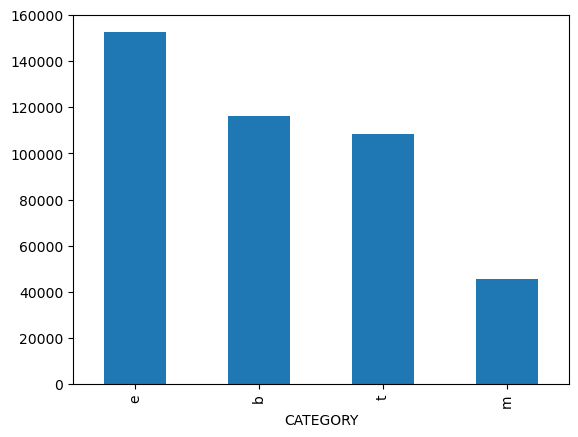

In [20]:
df['CATEGORY'].value_counts().plot(kind='bar')


<Axes: >

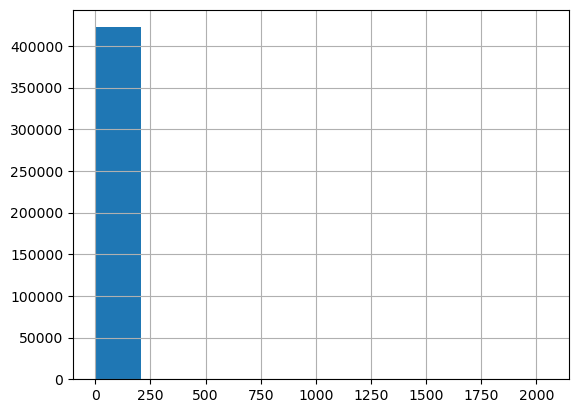

In [21]:
df['word_count'] = df['TITLE'].apply(lambda x: len(x.split()))
df['word_count'].hist()


In [22]:
df['word_count'].describe()

count    422419.000000
mean          9.257413
std           6.431410
min           1.000000
25%           7.000000
50%           9.000000
75%          11.000000
max        2045.000000
Name: word_count, dtype: float64

In [23]:
df['word_count'].quantile(0.95), df['word_count'].quantile(0.99)

(14.0, 15.0)

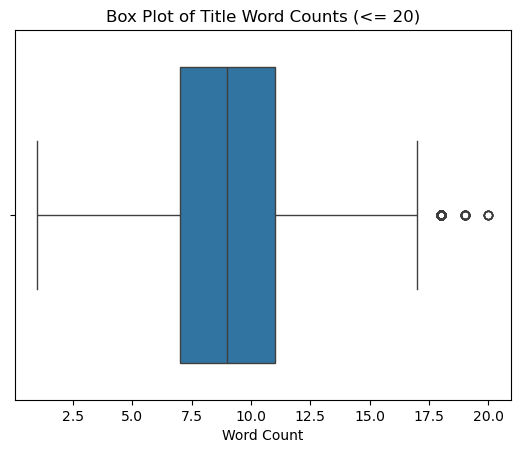

In [24]:
sns.boxplot(data=df[df['word_count'] <= 20], x='word_count')
plt.title("Box Plot of Title Word Counts (<= 20)")
plt.xlabel("Word Count")
plt.show()


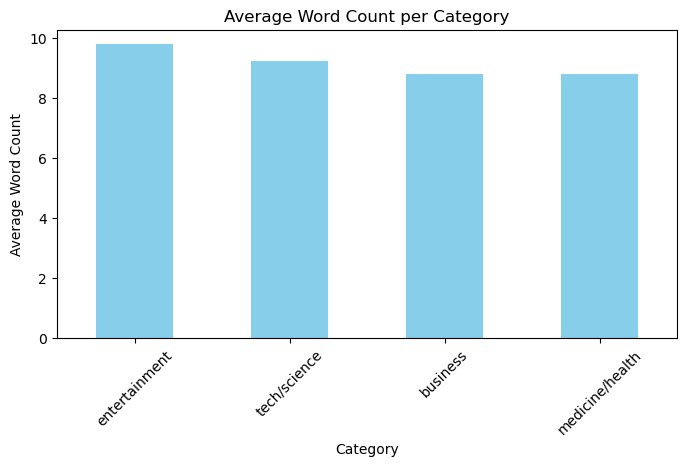

In [25]:
avg_word_counts = df.groupby('category_full')['word_count'].mean().sort_values(ascending=False)

avg_word_counts.plot(kind='bar', figsize=(8, 4), color='skyblue')
plt.title('Average Word Count per Category')
plt.xlabel('Category')
plt.ylabel('Average Word Count')
plt.xticks(rotation=45)
plt.show()


In [26]:
df[df['word_count'] <= 20]['word_count'].value_counts()

word_count
9     58184
8     57890
10    52096
7     49180
11    44528
12    36386
6     34865
13    26363
5     19805
14    16638
4      8993
15     8064
3      3521
16     2983
2      1606
17      917
18      220
1       134
19       31
20        6
Name: count, dtype: int64

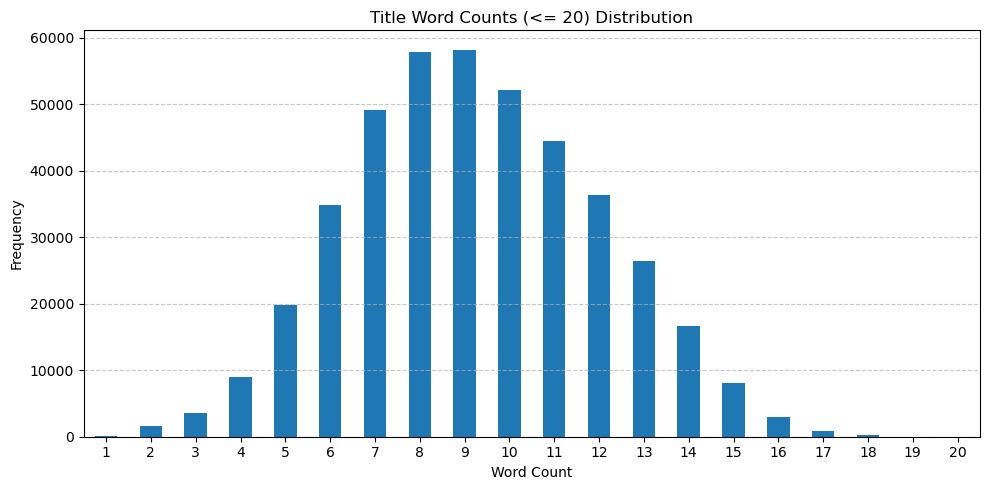

In [27]:
# Get value counts of word_count (filtered to <= 20)
word_count_freq = df[df['word_count'] <= 20]['word_count'].value_counts().sort_index()

# Plot
word_count_freq.plot(kind='bar', figsize=(10, 5))
plt.title("Title Word Counts (<= 20) Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.xticks(rotation=0)  # Keep labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


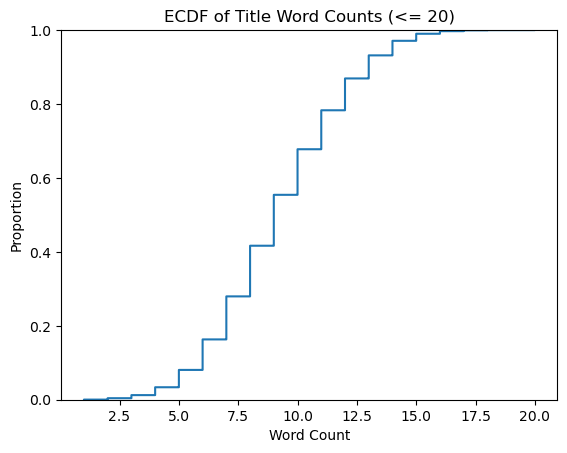

In [28]:
sns.ecdfplot(data=df[df['word_count'] <= 20], x='word_count')
plt.title("ECDF of Title Word Counts (<= 20)")
plt.xlabel("Word Count")
plt.ylabel("Proportion")
plt.show()


In [29]:
df[df['word_count'] > 20]

,TITLE,CATEGORY,category_full,word_count
69473,Love & Hip-Hop' Star Benzino Shot By Nephew En...,e,entertainment,1364
93797,Peaches has died. We are beyond pain.\thttp://...,e,entertainment,2045
98518,I don't know why I'm a sex symbol' says smould...,e,entertainment,71
110870,Hunger Games' top winner at MTV Movie Awards\t...,e,entertainment,727
112847,"A few years ago, scientists calculated that be...",t,tech/science,1837
194882,I never thought I'd be in love” says Angelina ...,e,entertainment,1816
210277,The Best Reactions To The Supposed Video of So...,e,entertainment,201
279114,The Fault In Our Stars' to release in India on...,e,entertainment,287
391520,"More Japanese Xbox One Games In Development, A...",t,tech/science,1030


In [30]:
# Check out a sample very long title
# seems like multiple headlines into a single row
#@TODO: perhaps we can clean up and divide this to multiple rows?
# for now, we have enough data to work with though.
df.iloc[194882]['TITLE'][:1000]

"I never thought I'd be in love” says Angelina Jolie\thttp://www.shanghaidaily.com/article/article_xinhua.aspx\\?id=217113\tShanghai Daily \\(subscription\\)\te\tdSK9w1sX3_u4D4MgvroyRJ-CcxxAM\twww.shanghaidaily.com\t1399574518790\n195219\tAngelina Jolie: I never thought I'd be in love but Brad Pitt and I drive each other  ...\thttp://www.nowmagazine.co.uk/celebrity-news/552980/angelina-jolie-i-never-thought-i-d-be-in-love-but-brad-pitt-and-i-drive-each-other-beautifully-crazy\tNow Magazine Online\te\tdSK9w1sX3_u4D4MgvroyRJ-CcxxAM\twww.nowmagazine.co.uk\t1399574519022\n195220\tAngelina Jolie supports kidnapped Nigerian girls and reveals secrets about love  ...\thttp://www.standartnews.com/english/read/angelina_jolie_supports_kidnapped_nigerian_girls_and_reveals_secrets_about_love_with_brad_pitt-3582.html\tStandart News\te\tdSK9w1sX3_u4D4MgvroyRJ-CcxxAM\twww.standartnews.com\t1399574519245\n195221\tAngelina Jolie Reveals Working With Daughter Vivienne On Maleficent Was 'So  ...\thttp://w

In [31]:
# Filter out the outliers
df = df[df['word_count'] <= 20]
df.shape

(422410, 4)

In [32]:
df.head()

,TITLE,CATEGORY,category_full,word_count
0,"Fed official says weak data caused by weather,...",b,business,12
1,Fed's Charles Plosser sees high bar for change...,b,business,12
2,US open: Stocks fall after Fed official hints ...,b,business,11
3,"Fed risks falling 'behind the curve', Charles ...",b,business,9
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b,business,8


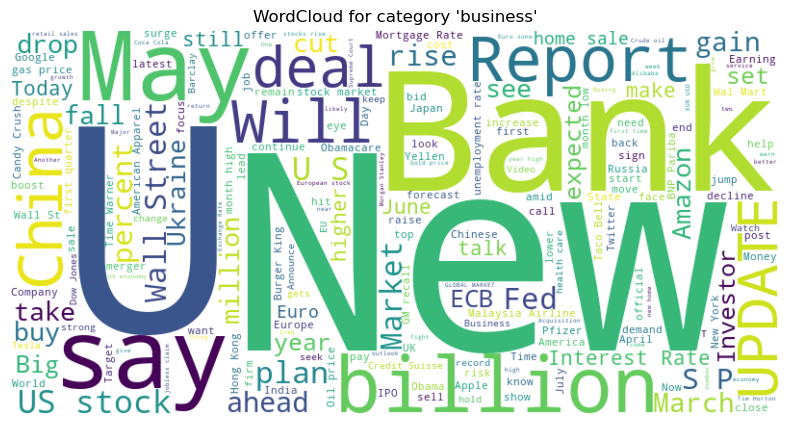

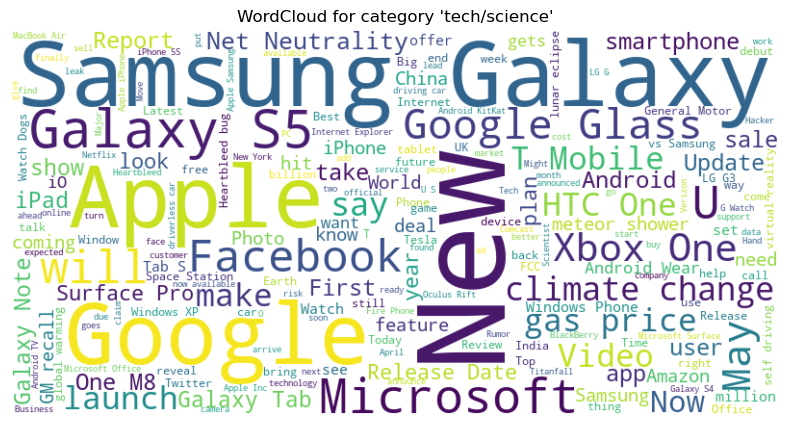

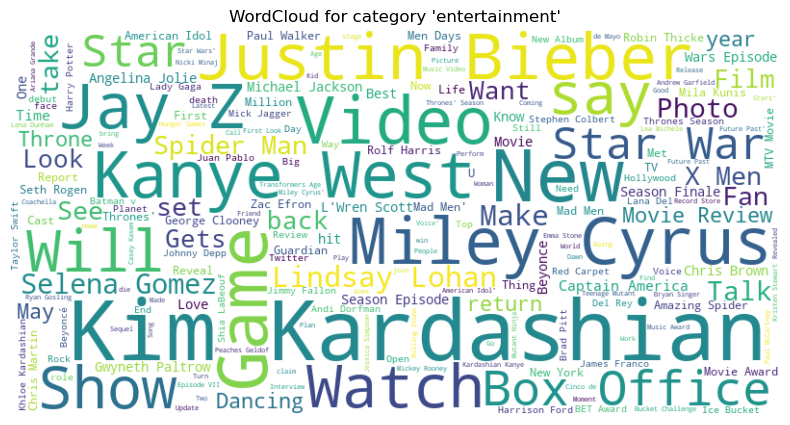

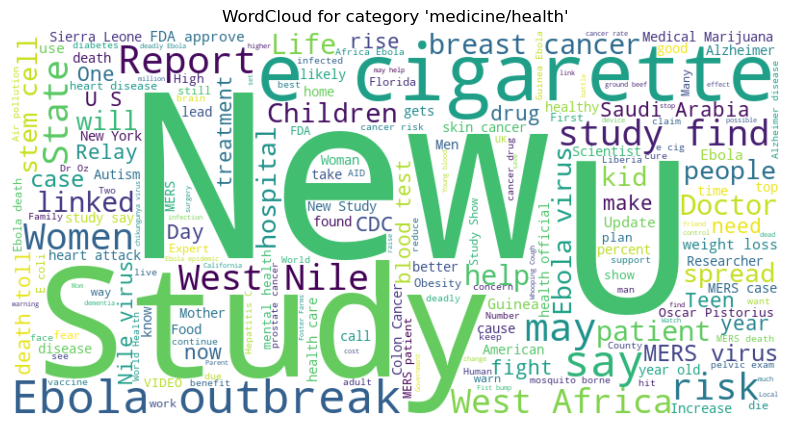

In [33]:
# Visualize word frequency per category to spot patterns.

for cat in df['category_full'].unique():
    text = ' '.join(df[df['category_full'] == cat]['TITLE'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for category '{cat}'")
    plt.show()

    print('==' * 55)

In [34]:
def show_titles_by_category(category_input, n=5):
    # Category mapping
    category_map = {
    'b': 'business',
    'e': 'entertainment',
    'm': 'medicine/health',
    't': 'tech/science'
    }

    # Normalize input
    if category_input in category_map:
        category_full = category_map[category_input]
    elif category_input in category_map.values():
        category_full = category_input
    else:
        print("Invalid category. Use 'b', 'e', 'm', 't' or full names like 'business'.")
        return

    # Filter and display
    sample_titles = df[df['category_full'] == category_full]['TITLE'].sample(n)
    
    print(f"\nSample titles from category: {category_full.upper()}\n" + "-"*40)
    for i, title in enumerate(sample_titles, 1):
        print(f"{i}. {title}")


In [35]:
show_titles_by_category('t', n=3)



Sample titles from category: TECH/SCIENCE
----------------------------------------
1. Curiosity Scheduled to Continue its Journey towards Mount Sharp
2. NASA's Kepler discovers first Earth-size planet in the 'habitable zone' of another  ...
3. Report: Apple on verge of buying Beats for $3.2B


In [36]:
show_titles_by_category('entertainment', n=5)


Sample titles from category: ENTERTAINMENT
----------------------------------------
1. Ice Cube on 22 Jump Street, Friday, and N.W.A.
2. 'Orphan Black': Tatiana Maslany on what she can do even better in season 2
3. Kristen Bell, Dax Shepard expecting second child
4. Taylor Swift cancels Thailand concert due to...
5. Bryan Cranston, Elizabeth Olsen and Aaron Taylor-Johnson star in Godzilla


In [37]:
show_titles_by_category('m')


Sample titles from category: MEDICINE/HEALTH
----------------------------------------
1. Dr. Oz on Green Coffee Bean
2. Baptist Health Lexington ranked top hospital in Kentucky
3. Frostie, the baby goat is back in action after being fitted with a special wheelchair
4. Asian meth demand drives record production: UN
5. Surgery not 'best option' for Jim Kelly


In [38]:
show_titles_by_category('b')


Sample titles from category: BUSINESS
----------------------------------------
1. Dollar Snaps Five-Day Losing Stretch Amid Drop in Risk Appetite
2. Alibaba IPO Could Hit Yahoo! Revenue Growth
3. Protest at McDonald's Headquarters Leads to Dozens of Arrests
4. UPDATE 1-IAC increases stake in Tinder -report
5. Divided Supreme Court strikes down part of EPA's greenhouse gas regulations  ...


# Upload Clean Data to S3

In [39]:
BUCKET_NAME

'news-headlines-4cls'

In [40]:
S3_KEY

'training_data/uci-news-aggregator.csv'

In [41]:
# Create S3 client
s3 = boto3.client('s3')

# 1. Delete the old file
s3.delete_object(Bucket=BUCKET_NAME, Key=S3_KEY)
print("Old file deleted.")

# 2. Upload the cleaned DataFrame
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False)

s3.put_object(Bucket=BUCKET_NAME, Key=S3_KEY, Body=csv_buffer.getvalue())
print("Cleaned file uploaded.")


Old file deleted.
Cleaned file uploaded.


In [42]:
df = pd.read_csv(f's3://{BUCKET_NAME}/{S3_KEY}', low_memory=False)
df.shape

(422410, 4)

In [43]:
df.sample(10)

,TITLE,CATEGORY,category_full,word_count
51742,Average U.S. 30-year mortgage rate rises to 4....,b,business,10
131551,Diabetic heart attacks and strokes falling,m,medicine/health,6
329696,HP wins dismissal of lawsuit linked to ex-CEO ...,b,business,10
336965,"Man Stabbed At BET Awards Pre-Show Party, Anot...",e,entertainment,12
91123,Cary Brown: The wage gap in Vermont on Equal P...,b,business,12
254650,GLOBAL MARKETS-World equity indexes up on US d...,b,business,12
264479,Apple agrees to buy Irish tax-linked Beats for...,t,tech/science,9
421419,Report: 'Full House' Revival In The Works,e,entertainment,7
410047,Fairfax's Prem Watsa faces probe from Quebec r...,b,business,11
369254,Justin Bieber shares video of dancing Tom Hanks,e,entertainment,8


# Delete the S3 Bucket

In [44]:

# s3 = boto3.resource('s3')
# bucket = s3.Bucket(BUCKET_NAME)

# # Step 1: Delete all objects (required before deleting bucket)
# print(f"🧹 Deleting all objects in bucket '{BUCKET_NAME}'...")
# bucket.objects.all().delete()

# # Step 2: Delete the bucket
# print(f"🪓 Deleting bucket '{BUCKET_NAME}'...")
# bucket.delete()

# print("✅ Bucket deleted.")
